In [1]:
# !pip install transformers[sentencepiece]
# !pip install datasets
# !pip install accelerate -U
# !pip install evaluate
# !pip install pyvi
# !pip install torch

In [1]:
PHOBERT_CHECKPOINT = r"vinai/phobert-base-v2"
INPUT_MAPPING = {'negative': 0, 'neutral': 1, 'positive': 2}
OUTPUT_MAPPING = {'LABEL_0': 'negative', 'LABEL_1': 'neutral', 'LABEL_2': 'positive'}

NUMS_LABEL = 3
SEED = 42
SENTIMENT_ANALYSIS_CHECKPOINT = r"..\python\models\trained_bert\phoBert_v2_Trainer_30k"
SPECIALIZED_STOCK_CHECKPOINT = r"..\python\models\trained_bert\phoBert_v2_specialized"
DECISION_THRESHOLD = 0.69

# Support functions

In [2]:
import torch
import re
import pandas as pd

In [3]:
from pyvi import ViTokenizer

def text_preprocessing(text):

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Segmentation
    text = ViTokenizer.tokenize(text)

    return text

def preprocess_data(data):
    preprocessed_data = pd.DataFrame()
    preprocessed_data['input'] = data['input'].apply(text_preprocessing)
    preprocessed_data['label'] = data['label'].replace(INPUT_MAPPING)
    return preprocessed_data

In [23]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import RobertaForSequenceClassification

def prepare_raw_data(df, seed = SEED):
    raw_data = Dataset.from_pandas(df)
    dataset_dict = raw_data.train_test_split(test_size=0.3, shuffle=True, seed=seed)

    # Access the train and test splits
    train_data = dataset_dict["train"]
    test_data = dataset_dict["test"]

    # Split the test_data into eval and test sets
    test_data_dict = test_data.train_test_split(test_size=0.5, shuffle=True, seed=seed)

    # Access the train and eval splits
    eval_data = test_data_dict["train"]
    test_data = test_data_dict["test"]

    # Create a DatasetDict object and combine the datasets
    raw_datasets = DatasetDict({"train": train_data, "validation": eval_data, "test": test_data})
    
    return raw_datasets, raw_dataset

def prepare_for_trainer(df, checkpoint, seed = SEED):
    
    raw_datasets, raw_dataset = prepare_raw_data(df)
    phobert = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=NUMS_LABEL)

    CHECKPOINT = r"vinai/phobert-base-v2" 
    tokenizer = AutoTokenizer.from_pretrained(CHECKPOINT)
    
    def tokenize_function(example):
        return tokenizer(example["input"], padding = True,  truncation=True, max_length = 256)
    tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding= True)

    return phobert, tokenizer, data_collator, tokenized_datasets, raw_datasets, raw_dataset


In [5]:
import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

In [6]:
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute the metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def decision_threshold(row):
    if row['score'] > DECISION_THRESHOLD:
        return row['label']
    else:
        return 'neutral'

def process_results(pipeline_results):
    results_df = pd.DataFrame(pipeline_results)
    results_df['label'] = results_df['label'].replace(OUTPUT_MAPPING)
    results_df['final_label'] = results_df.apply(decision_threshold, axis=1)
    return results_df

def evaluate_model(pipeline_results, labels):
    results_df = process_results(pipeline_results)
    predictions = results_df["label"]
    y_pred = predictions.to_numpy()
    
    labels = pd.Series(labels)
    labels = labels.replace({v:k for k,v in INPUT_MAPPING.items()})
    y_test = labels.to_numpy()
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    
    return {"accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "confusion_matrix": cm
            }

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Sentiment Analysis fine-tuning

## Preprocess

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# prefix = r"/content/gdrive/MyDrive/Sentiment Analysis/"
# data_path = prefix + r"/inputs/30k_ecommerce_review.csv"
data_path = r"..\python\inputs\30k_ecommerce_review.csv"
data = pd.read_csv(data_path)
data

,comment,label,rate,Unnamed: 3
0,Áo bao đẹp ạ!!,POS,5,NaN
1,Tuyệt vời !,POS,5,NaN
2,2day ao khong giong trong.,NEG,1,NaN
3,"Mùi thơm,bôi lên da mềm da.",POS,5,NaN
4,"Vải đẹp, dày dặn.",POS,5,NaN
...,...,...,...,...
31455,Không đáng tiền.,NEG,1,NaN
31456,Quần rất đẹp.,POS,5,NaN
31457,Hàng đẹp đúng giá tiền.,POS,5,NaN
31458,Chất vải khá ổn.,POS,4,NaN


In [ ]:
data['input'] = data['comment']
data['label'] = data['label']

In [ ]:
# Mapping dictionary
mapping = {'NEG': 'negative', 'NEU': 'neutral', 'POS': 'positive'}

# Replace values
data['label'] = data['label'].replace(mapping)
data

,comment,label,rate,Unnamed: 3,input
0,Áo bao đẹp ạ!!,positive,5,NaN,Áo bao đẹp ạ!!
1,Tuyệt vời !,positive,5,NaN,Tuyệt vời !
2,2day ao khong giong trong.,negative,1,NaN,2day ao khong giong trong.
3,"Mùi thơm,bôi lên da mềm da.",positive,5,NaN,"Mùi thơm,bôi lên da mềm da."
4,"Vải đẹp, dày dặn.",positive,5,NaN,"Vải đẹp, dày dặn."
...,...,...,...,...,...
31455,Không đáng tiền.,negative,1,NaN,Không đáng tiền.
31456,Quần rất đẹp.,positive,5,NaN,Quần rất đẹp.
31457,Hàng đẹp đúng giá tiền.,positive,5,NaN,Hàng đẹp đúng giá tiền.
31458,Chất vải khá ổn.,positive,4,NaN,Chất vải khá ổn.


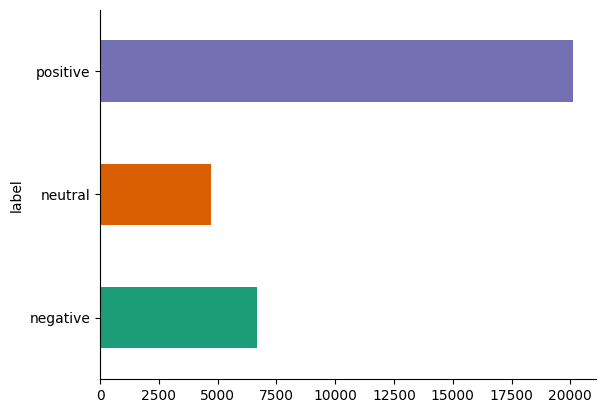

In [ ]:
# @title label

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
preprocessed_data = preprocess_data(data)
preprocessed_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_28288\415774224.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preprocessed_data['label'] = data['label'].replace(MAPPING)


,input,label
0,Áo bao đẹp ạ ! !,1
1,Tuyệt_vời !,1
2,2day ao khong giong trong .,0
3,"Mùi thơm , bôi lên da mềm da .",1
4,"Vải đẹp , dày_dặn .",1
...,...,...
31455,Không đáng tiền .,0
31456,Quần rất đẹp .,1
31457,Hàng đẹp đúng giá tiền .,1
31458,Chất vải khá ổn .,1


In [ ]:
# data = data[0:100]
# data

## Initialize, tokenize, then train model

In [ ]:
# Getting ready for trainer
phobert, tokenizer, data_collator, tokenized_datasets, _, _ = prepare_for_trainer(df = preprocessed_data, checkpoint = PHOBERT_CHECKPOINT)

tokenized_datasets

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/22022 [00:00<?, ? examples/s]

Map:   0%|          | 0/4719 [00:00<?, ? examples/s]

Map:   0%|          | 0/4719 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 22022
    })
    validation: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4719
    })
    test: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4719
    })
})

In [ ]:
# import numpy as np
# import evaluate

# # Setup evaluation
# metric = evaluate.combine(["accuracy", "recall", "precision", "f1", "confusion_matrix"])
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)


In [ ]:
from transformers import TrainingArguments, Trainer

# output_dir = prefix + r"/trainer_outputs/sentiment_analysis"

# training_args = TrainingArguments("test-trainer")

output_dir = r"D:\test\sentiment_analysis"
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # warmup_steps=500,
    # weight_decay=0.01,
    # logging_dir=r"D:\OneDrive - fpts.com.vn\Obsidian Vault\9 - Files\Khoa học Dữ liệu\python\models\trained_bert\logs",
    # logging_steps=10
)

trainer = Trainer(
    phobert,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
trainer.train
# trainer.save_model(SENTIMENT_ANALYSIS_CHECKPOINT)

## Debug (if necessary)

In [ ]:
trainer.train_dataset[0]

{'content': 'Giao nhầm hàng , ib shop k trả_lời 😓 😓 😓 .',
 'label': 0,
 'input_ids': [0,
  6460,
  3399,
  119,
  4,
  39913,
  9405,
  1947,
  799,
  3,
  3,
  3,
  5,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [ ]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])

'<s> Giao nhầm hàng, ib shop k trả_lời <unk> <unk> <unk>. </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

In [ ]:
trainer.train_dataset[0].keys()

dict_keys(['content', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
trainer.train_dataset.features['label'].names

AttributeError: 'Value' object has no attribute 'names'

In [ ]:
dir(trainer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activate_neftune',
 '_add_sm_patterns_to_gitignore',
 '_created_lr_scheduler',
 '_deactivate_neftune',
 '_finish_current_push',
 '_gather_and_numpify',
 '_get_collator_with_removed_columns',
 '_get_eval_sampler',
 '_get_learning_rate',
 '_get_output_dir',
 '_get_train_sampler',
 '_globalstep_last_logged',
 '_hp_search_setup',
 '_inner_training_loop',
 '_issue_warnings_after_load',
 '_load_best_model',
 '_load_from_checkpoint',
 '_load_optimizer_and_scheduler',
 '_load_rng_state',
 '_loggers_initialized',
 '_maybe_log_save_evaluate',
 '_memory_tracker',
 '_move_model_to_device',
 '_nested_gather',
 '_prepare_input',
 '_p

In [ ]:
label_encoder.inverse_transform([0, 1 ,2])

array(['NEG', 'NEU', 'POS'], dtype=object)

# Specialization

In [13]:
import pandas as pd

# stock_path = prefix + r"/inputs/df_stock_1804.xlsx"
stock_path = r"..\python\inputs\df_stock_1804.xlsx"
stock_df = pd.read_excel(stock_path)
stock_df

,url,lastmod,stockCode,content,sentiment
0,https://cafef.vn/pvoil-len-tieng-vu-he-thong-b...,2024-04-03T17:21:38+07:00,PVO,"PVOIL bị tấn công bất hợp pháp, hệ thống công ...",negative
1,https://cafef.vn/vinpearl-bao-lai-nam-thu-2-li...,2024-04-03T19:22:19+07:00,VPL,Vinpearl công bố thông tin tình hình tài chính...,positive
2,https://cafef.vn/vinpearl-bao-lai-nam-thu-2-li...,2024-04-03T19:22:19+07:00,VIC,Vingroup tách Vinpearl và thành lập công ty co...,positive
3,https://cafef.vn/dabaco-dbc-dat-muc-tieu-loi-n...,2024-04-03T16:53:53+07:00,DBC,Dabaco Vietnam Group (DBC) announced their amb...,positive
4,https://cafef.vn/cong-ty-mai-tang-sap-tra-co-t...,2024-04-03T15:36:53+07:00,CPH,CTCP Phục vụ Mai táng Hải Phòng (MCK: CPH) thô...,neutral
...,...,...,...,...,...
783,https://cafef.vn/chung-khoan-nh-viet-nam-khai-...,2024-03-26T07:14:15+07:00,CEO,Ông Kim Jong Seok – CEO Chứng khoán NH Việt Na...,positive
784,https://cafef.vn/chung-khoan-nh-viet-nam-khai-...,2024-03-26T07:14:15+07:00,NHS,Chứng khoán NH Việt Nam là thành viên thuộc tậ...,positive
785,https://cafef.vn/chung-khoan-nh-viet-nam-khai-...,2024-03-26T07:14:15+07:00,2023,"Năm 2023, NHSV ghi nhận kết quả kinh doanh tíc...",positive
786,https://cafef.vn/chuyen-dong-moi-tu-lien-doanh...,2024-03-26T08:27:58+07:00,YP2C,Khởi công dự án Industrial Centre YP2C thuộc K...,neutral


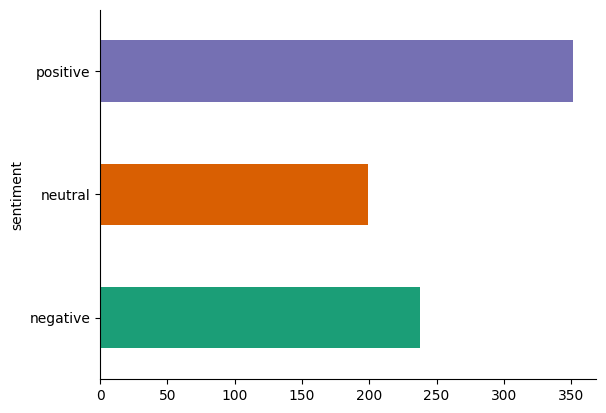

In [14]:
# @title sentiment

from matplotlib import pyplot as plt
import seaborn as sns
stock_df.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [15]:
stock_df['input'] = stock_df['content']
stock_df['label'] = stock_df['sentiment']

In [16]:
preprocessed_stock_data = preprocess_data(stock_df)
preprocessed_stock_data.dropna()
preprocessed_stock_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_22756\2000335083.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preprocessed_data['label'] = data['label'].replace(INPUT_MAPPING)


,input,label
0,"PVOIL bị tấn_công bất_hợp_pháp , hệ_thống công...",0
1,Vinpearl công_bố thông_tin tình_hình tài_chính...,2
2,Vingroup tách Vinpearl và thành_lập công_ty_co...,2
3,Dabaco Vietnam_Group ( DBC ) announced their a...,2
4,CTCP Phục_vụ Mai_táng Hải_Phòng ( MCK : CPH ) ...,1
...,...,...
783,Ông Kim_Jong_Seok – CEO Chứng_khoán NH Việt_Na...,2
784,Chứng_khoán NH Việt_Nam là thành_viên thuộc tậ...,2
785,"Năm 2023 , NHSV ghi_nhận kết_quả kinh_doanh tí...",2
786,Khởi_công dự_án Industrial Centre YP2C thuộc K...,1


In [17]:
# Getting ready for trainer
# sa_model_path = prefix + r"/models/phobert_30k_reviews"
# sa_model_path = prefix + r"/trainer_outputs/sentiment_analysis/checkpoint-1770"

sa_model_path = SENTIMENT_ANALYSIS_CHECKPOINT
sa_model, tokenizer, data_collator, tokenized_stock_datasets, , _ = prepare_for_trainer(df = preprocessed_stock_data, checkpoint = sa_model_path)

tokenized_stock_datasets

Map:   0%|          | 0/551 [00:00<?, ? examples/s]

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 551
    })
    validation: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 118
    })
    test: Dataset({
        features: ['input', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 119
    })
})

In [18]:
from transformers import TrainingArguments, Trainer

# output_specialization_dir = prefix + r"/trainer_outputs/stock_specialization"

output_specialization_dir = r"D:\test\stock_specialization"

training_stock_args = TrainingArguments(
    output_dir=output_specialization_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    # save_total_limit=1,
    # warmup_steps=500,
    # weight_decay=0.01,
    # logging_dir=r"D:\OneDrive - fpts.com.vn\Obsidian Vault\9 - Files\Khoa học Dữ liệu\python\models\trained_bert\logs",
    # logging_steps=10
)

trainer_stock = Trainer(
    sa_model,
    training_stock_args,
    train_dataset=tokenized_stock_datasets["train"],
    eval_dataset=tokenized_stock_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [19]:
trainer_stock.train()
# trainer_stock.save_model(SPECIALIZED_MODEL_PATH)


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.35388121008872986, 'eval_accuracy': 0.8728813559322034, 'eval_runtime': 29.5138, 'eval_samples_per_second': 3.998, 'eval_steps_per_second': 0.136, 'epoch': 1.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.33060458302497864, 'eval_accuracy': 0.8898305084745762, 'eval_runtime': 28.2095, 'eval_samples_per_second': 4.183, 'eval_steps_per_second': 0.142, 'epoch': 2.0}


  0%|          | 0/4 [00:00<?, ?it/s]

{'eval_loss': 0.3087550103664398, 'eval_accuracy': 0.8983050847457628, 'eval_runtime': 28.6075, 'eval_samples_per_second': 4.125, 'eval_steps_per_second': 0.14, 'epoch': 3.0}
{'train_runtime': 1100.8484, 'train_samples_per_second': 1.502, 'train_steps_per_second': 0.049, 'train_loss': 0.2858847865351924, 'epoch': 3.0}


TrainOutput(global_step=54, training_loss=0.2858847865351924, metrics={'train_runtime': 1100.8484, 'train_samples_per_second': 1.502, 'train_steps_per_second': 0.049, 'train_loss': 0.2858847865351924, 'epoch': 3.0})

# Predict with pipeline and test

In [18]:
from transformers import pipeline

sentiment_classifier = pipeline("sentiment-analysis", model = SPECIALIZED_STOCK_CHECKPOINT, tokenizer = PHOBERT_CHECKPOINT)

In [19]:
dataset = raw_stock_datasets["test"]
dataset["input"]

['Cổ_phiếu PDR được mua ròng 153 tỷ đồng trong tuần qua .',
 "Với nhà đầu_tư giá_trị , công_việc có vẻ ' nhàn ' hơn khi chỉ cần tìm được cổ_phiếu phù_hợp để nắm giữ dài_hạn .",
 'Ít ai biết thương_vụ này thực_tế được thúc_đẩy 5 – 6 năm , trước cả thị_trường Mỹ .',
 'MSN là 1 trong 9 cổ_phiếu được hưởng lợi trong sóng nâng hạng',
 'Ông Phạm_Thanh_Nghị là Tổng_giám_đốc , người đại_diện pháp_luật của Công_ty Dây đồng Việt_Nam CFT – công_ty_con của CTCP Điện_lực Gelex .',
 'Ủy_ban Chứng_khoán Nhà_nước ( UBCKNN ) cũng đã lên_tiếng cảnh_báo về sự_cố của VNDirect .',
 'Vinhomes cũng nâng_cấp hệ_thống kinh_doanh online , hướng tới nâng cao trải nghiệm mua hàng , minh_bạch_hóa chính_sách và giá_cả sản_phẩm , tập_trung vào việc triển_khai các dự_án mới tiềm_năng đã hoàn_thiện thủ_tục pháp_lý .',
 'Cổ_phiếu MCH được khối ngoại mua ròng với giá_trị 1,2 tỷ đồng .',
 'Bông_Sen trong danh_sách 762 công_ty có liên_quan đến Vạn_Thịnh_Phát , bà Trương Mỹ_Lan khai nhận Bông_Sen là công_ty của gia_đình bà

In [20]:
results = sentiment_classifier(dataset["input"])
results

[{'label': 'LABEL_2', 'score': 0.9935801029205322},
 {'label': 'LABEL_2', 'score': 0.9731795191764832},
 {'label': 'LABEL_2', 'score': 0.48922398686408997},
 {'label': 'LABEL_2', 'score': 0.9927409291267395},
 {'label': 'LABEL_1', 'score': 0.9044064879417419},
 {'label': 'LABEL_0', 'score': 0.6937671899795532},
 {'label': 'LABEL_2', 'score': 0.9730701446533203},
 {'label': 'LABEL_2', 'score': 0.9933551549911499},
 {'label': 'LABEL_1', 'score': 0.819850742816925},
 {'label': 'LABEL_2', 'score': 0.7781935930252075},
 {'label': 'LABEL_1', 'score': 0.874737560749054},
 {'label': 'LABEL_1', 'score': 0.8769955635070801},
 {'label': 'LABEL_0', 'score': 0.9785435795783997},
 {'label': 'LABEL_1', 'score': 0.904969334602356},
 {'label': 'LABEL_0', 'score': 0.9699675440788269},
 {'label': 'LABEL_2', 'score': 0.7722381353378296},
 {'label': 'LABEL_2', 'score': 0.9925342798233032},
 {'label': 'LABEL_2', 'score': 0.6634453535079956},
 {'label': 'LABEL_0', 'score': 0.9791725277900696},
 {'label': 'LA

In [21]:
print(evaluate_model(results, dataset["label"]))
# results_df

{'accuracy': 0.8487394957983193, 'precision': 0.8438629997453526, 'recall': 0.8487394957983193, 'f1': 0.8412092109571101, 'confusion_matrix': array([[34,  3,  0],
       [ 6, 19,  7],
       [ 0,  2, 48]], dtype=int64)}
